# So Many Bronze

In a [recent video](https://www.youtube.com/watch?v=kuvKukJNmzI), Hank Green nerd-sniped me by asking a question I couldn't not answer.

At [one point in the video](https://youtu.be/kuvKukJNmzI?t=319), he shows "a graph of the last 20 years of Olympic games showing the gold, silver, and bronze medals from continental Europe. And it "shows continental Europe having significantly more bronze medals than gold medals."

<img width="400" src="https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/europe_medals.png">

Hank wonders why and offers a few possible explanations, finally settling on the one I think is correct:

> ... the increased numbers of athletes who come from European countries weight them more toward bronze, which might actually be a more randomized medal. Placing gold might just be a better judge of who is first, because gold medal winners are more likely to be truer outliers, while bronze medal recipients are closer to the middle of the pack. And so randomness might play a bigger role, which would mean that having a larger number of athletes gives you more bronze medal winners and more athletes is what you get when you lump a bunch of countries together.

In the following simulations, I show that this explanation is plausible.
If you like this kind of analysis, you might like my book, [*Probably Overthinking It*](https://probablyoverthinking.it).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/olympics.ipynb).

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/examples/utils.py"
)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

## Simulate the Olympics

The following function takes a random distribution, generates a population of athletes with random abilities, and returns the top three. 

In [4]:
def generate(dist, n, label):
    """Generate the top 3 athletes from a country with population n.
    
    dist: distribution of ability
    n: population
    label: name of country
    """
    # generate a sample with the given size
    sample = dist.rvs(n)
    
    # select the top 3
    top3 = top_k = np.sort(sample)[-3:]
    
    # put the results in a DataFrame with country labels
    df = pd.DataFrame(dict(ability=top3))
    df['label'] = label
    return df

Here's an example based on a normal distribution with mean 500 and standard deviation 100.

In [5]:
from scipy.stats import norm

dist = norm(500, 100)
generate(dist, 300, 'Example')

,ability,label
0,746.324211,Example
1,772.016917,Example
2,885.273149,Example


Now let's simulate the trials in two regions: 

* A single large country called "UnaGrandia", with population of 30,000 athletes,

* And a group of ten smaller countries called "MultiParvia" with 3,000 athletes each

In [6]:
def run_trials(dist):
    """Simulate the trials.
    
    dist: distribution of ability
    """
    # generate athletes from 10 countries with population 30
    dfs = [generate(dist, 3000, 'MultiParvia') for i in range(10)]
    
    # add in athletes from one country with population 300
    dfs.append(generate(dist, 30000, 'UnaGrandia'))
    
    # combine into a single DataFrame
    athletes = pd.concat(dfs)
    return athletes

The result is 33 athletes, 3 from UnaGrandia and 30 from the various countries of MultiParvia.

In [7]:
athletes = run_trials(dist)
athletes['label'].value_counts()

label
MultiParvia    30
UnaGrandia      3
Name: count, dtype: int64

Here's what the distribution of ability looks like.

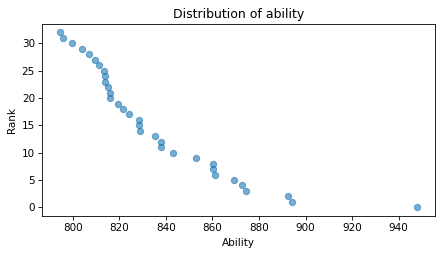

In [8]:
from empiricaldist import Surv
from utils import decorate

surv_ability = Surv.from_seq(athletes['ability'], normalize=False)
surv_ability.plot(style='o', alpha=0.6, label='')
decorate(xlabel='Ability', ylabel='Rank', title='Distribution of ability')

Because we've selected the largest values from the distribution of ability, the result is skewed to the right -- that is, there are a few extreme outliers who have the best chances of winning, and a middle of the pack that have fewer chances (with a reminder that it's a pretty elite pack to be in the middle of).

Now let's simulate the competition.
The following function takes the distribution of ability and an additional parameter, `std`, that controls the randomness of the results.

* When `std` is 0, the outcome of the competition depends only on the abilities of the athletes -- the athlete with the highest ability wins every time.

* As `std` increases, the outcome is more random, so an athlete with a lower ability has a better chance of beating an athlete with higher ability.

In [9]:
medals = ['Gold', 'Silver', 'Bronze']

def compete(dist, std=0):
    """Simulate a competition.
    
    dist: distribution of ability
    std: standard deviation of randomness
    """
    # run the trials
    athletes = run_trials(dist)
    
    # add a random factor to ability to get scores
    randomness = norm(0, std).rvs(len(athletes))
    athletes['score'] = athletes['ability'] + randomness
    
    # select and return athlete with top 3 scores
    podium = athletes.nlargest(3, columns='score')
    podium['medal'] = medals
    return podium

The result shows the abilities of each winner, which region they are from, their score in the competition, and the medal they won.

In [10]:
compete(dist, std=10)

,ability,label,score,medal
2,920.202590,UnaGrandia,926.182143,Gold
0,876.618008,UnaGrandia,884.973475,Silver
1,876.623360,UnaGrandia,877.887775,Bronze


Now let's simulate multiple events.
The following function takes the distribution of ability again, along with the number of events and the amount of randomness in the outcomes.

In [11]:
def games(dist, num_events, std=0):
    """Simulate multiple games.
    
    dist: distribution of abilities
    num_events: how many events are contested
    """
    dfs = [compete(dist, std) for i in range(num_events)]
    results = pd.concat(dfs)
    xtab = pd.crosstab(results['label'], results['medal'])
    return xtab[medals]

The result is a table that shows the number of each kind of medal won by each region.

In [12]:
table = games(dist, 100, std=20)
table

medal,Gold,Silver,Bronze
label,,,
MultiParvia,53,49,69
UnaGrandia,47,51,31


The following function plots the results.

In [13]:
colors = ['#FFD700', '#C0C0C0', '#CD7F32']

def plot_results(tables):
    plt.figure(figsize=(10, 3))

    for i, table in enumerate(tables):
        ax = plt.subplot(1, 6, i+1)
        plt.axhline(y=500, ls='--', color='gray', alpha=0.4)
        table.loc['MultiParvia'].plot.bar()
        plt.xticks(rotation=45)
        for bar, color in zip(ax.patches, colors):
            bar.set_color(color)
            
        if i>0:
            plt.yticks([])
        xlabel = 2004 + 4*i
        decorate(xlabel=xlabel, ylim=[0, 700], legend=False)
        
        for spine in ax.spines.values():
            spine.set_visible(False)

If there is no randomness in the outcomes, each region wins about half of the medals, and there is no excess of bronze medals for MultiParvia.

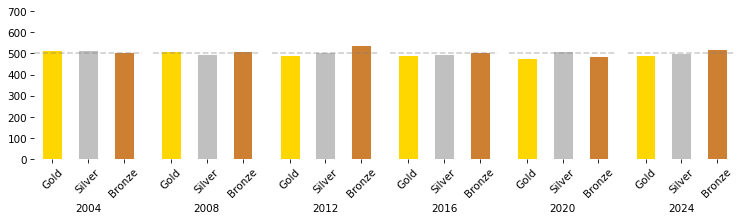

In [14]:
tables = [games(dist, 1000, std=0) for i in range(6)]

plot_results(tables)

However, if we add enough randomness that the outcome is not certain, we see a pattern that resembles the actual data:

* The two regions get about the same number of gold medals.

* MultiParvia gets more bronze medals, and possibly more silver medals, too.

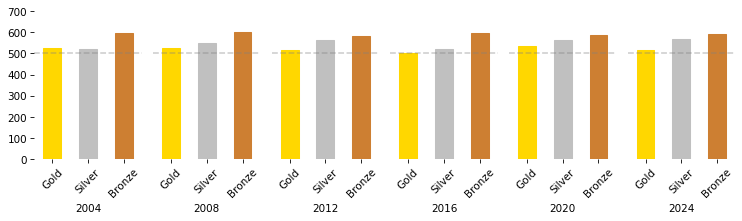

In [15]:
tables = [games(dist, 1000, std=20) for i in range(6)]

plot_results(tables)

The results here are more consistent that what we see in the real data because we simulated 1000 events.

If we increase the amount of randomness, the advantage of sending more athletes to the games is even stronger -- and it looks like it has an effect on the number of gold medals as well.

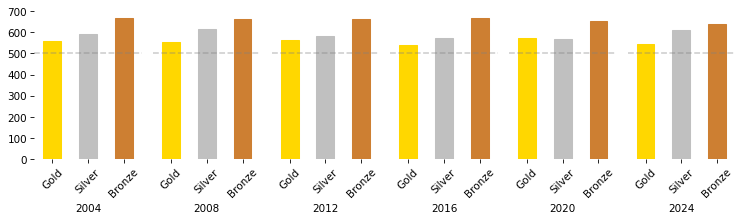

In [16]:
tables = [games(dist, 1000, std=30) for i in range(6)]

plot_results(tables)

## Lognormal distribution of ability

I was curious to know how the distribution of ability affects the result, so I tried the simulations with a lognormal distribution, too.
This choice might be more realistic because the distribution of ability in many fields follows a lognormal distribution -- see Chapter 4 of [*Probably Overthinking It*](https://probablyoverthinking.it) or [this article](https://www.allendowney.com/blog/2023/11/21/life-in-a-lognormal-world/)).

Here's a lognormal distribution that's a good match for the distribution of Elo scores in chess.

In [17]:
from scipy.stats import lognorm

m, s = 7.08959557, 0.32758329
dist2 = lognorm(s=s, scale=np.exp(m))

Here's what it looks like.

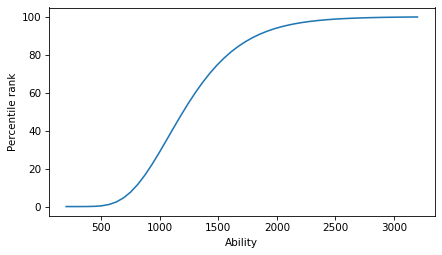

In [21]:
low, high = 200, 3200
qs = np.linspace(low, high)
ps = dist2.cdf(qs) * 100
plt.plot(qs, ps)

decorate(xlabel="Ability", ylabel="Percentile rank")

If we run the competition with this distribution, we can see that the scale of abilities is higher.

In [19]:
compete(dist2, std=100)

,ability,label,score,medal
0,4329.190762,UnaGrandia,4471.560302,Gold
2,4579.134646,UnaGrandia,4471.322015,Silver
2,4267.159885,MultiParvia,4272.824660,Bronze


And here's what the results look like.

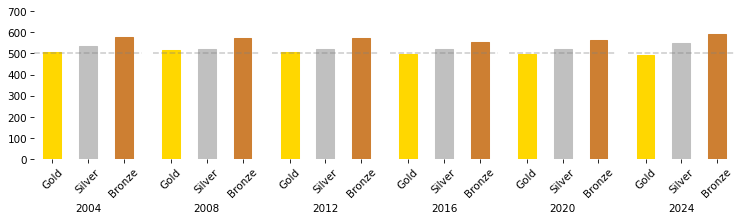

In [20]:
tables = [games(dist2, 1000, std=200) for i in range(6)]
plot_results(tables)

They are similar to the results with a normal distribution of abilities, so it seems like the shape of the distribution is not an essential reason for the excess of bronze medals.

## Conclusions

I think Hank is right. If you have two regions with the same population, and one is allowed to send more athletes to the games, it is not much more likely to win gold medals, but notably more likely to win silver and bronze medals -- and the size of the excess depends on how much randomness there is in the outcome of the events.

If you like this kind of analysis, you might like my book, [*Probably Overthinking It*](https://probablyoverthinking.it).

Copyright 2024 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).